In [1]:
%matplotlib inline

In [ ]:
from 3DRegionGrowing.segmentation_functions import resample
from preprocess import arrange_slices, normalization, creating_mask
from 3DRegionGrowing.automaticSeeding import find_seed #confirmar que não é o primeiro metodo
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io as spio
import pydicom
import time
from segmentation_metrics import compare_volumes_lighter, plot_results_segmentation_image, plotResultsSegmentationImage_WithContours, Dice, Jac, TruePR, VoluM, MutualI
from skimage import measure
import matplotlib.patches as mpatches
#from math import sqrt

def plotResultsSegmentationImage_WithContours2(truth_image_ori, prediction_segment, normal_image, contours):
    """Code adapted from KenobiShan and from kraskevich, 
    available on https://codereview.stackexchange.com/questions/177898/calculate-true-positive-false-positive-true-negative-and-false-negative-and-co
    This function creates a plot with four images, one from the ct scan with contours from the segmentations,
    another image representing the TP, FP, FN and TN of the segmentations, comparing with the ground truth,
    and two more images, one from the segmentations and other from the ground truth.
    - truth_image_ori - image from the ground truth
    - prediction_segment - image from the predicted segmentation from your code
    - normal_image - image from ct, from the same slice from the other images
    - contours - contours from the segmentation
    """
    prediction = prediction_segment.astype(np.uint8)
    truth_image = truth_image_ori.astype(np.uint8)

    output_image = np.empty(shape=(prediction.shape[0], prediction.shape[1], 4), dtype=np.uint8)

    true_positive_mask = np.logical_and(truth_image ==1 , prediction == 1)
    true_negative_mask = np.logical_and(truth_image ==0 , prediction == 0)
    false_positive_mask = np.logical_and(truth_image ==0 , prediction == 1)
    false_negative_mask = np.logical_and(truth_image ==1 , prediction == 0)
    double_mask = np.where(prediction == 2,1,0)
    background_mask = np.logical_and(truth_image ==0 , prediction == 0)
    
    # B-G-R-A
    red = [255, 0, 0, 255]
    green = [0, 255, 0, 255]
    blue = [0, 0, 255, 255]
    purple =  [128, 0, 255, 255]
    black = [0, 0, 0, 255]
    white = [0,0,0,0]

    output_image[background_mask] = black  
    output_image[true_positive_mask] = blue 
    output_image[true_negative_mask] = black 
    output_image[false_positive_mask] = purple
    output_image[false_negative_mask] = red  
    output_image[double_mask] = white
    
    fig_2 = plt.figure(figsize=(10,6))
    plt.axis('equal')
    fig_2.suptitle("Resultados Segmentação", fontsize=16)
    y = fig_2.add_subplot(2,2,1)
    y.axis('off')
    y.imshow(normal_image, interpolation='nearest',cmap = plt.cm.gray)
    for n, contour in enumerate(contours):
        y.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)

    x = fig_2.add_subplot(2,2,2)
    x.axis('off')
    black_patch = mpatches.Patch(color='black', label='True Negative')
    blue_patch = mpatches.Patch(color='blue', label='True Positive')
    red_patch = mpatches.Patch(color='red', label='False Negative')
    purple_patch = mpatches.Patch(color='purple', label='False Positive')
    white_patch = mpatches.Patch(color = 'white', label = 'Overlapped segmentations')
    if np.amax(double_mask)==1:
        plt.legend(handles=[black_patch, blue_patch, red_patch, purple_patch, white_patch])
    else:
        plt.legend(handles=[black_patch, blue_patch, red_patch, purple_patch])
    x.imshow(output_image)
   
    z = fig_2.add_subplot(2,2,3)
    z.axis('off')
    yellow_patch = mpatches.Patch(color ='yellow', label = "Segmented volume")
    if np.amax(double_mask)==1:
        green_patch= mpatches.Patch(color = 'green', label = "Overlapped")
        z.legend(handles=[yellow_patch, green_patch])
    else:

        abc = 1
    z.imshow(prediction_segment)
    z.set_title("Segmentation Mask")
    k = fig_2.add_subplot(2,2,4)
    k.axis('off')
    yellow_truth = mpatches.Patch(color = 'yellow', label = 'Ground truth')
    k.imshow(truth_image_ori)
    k.set_title("Ground truth")
    plt.show()

    return output_image,fig_2


slices_path = "G:/CTimagens/"
indices_path ="G:/Results/Lungs Mask/ok/Separate Lungs/"
seeds_path = "G:/Results/Seeds/"
separation_path = "G:/Results/Separator/"
centroid_path = "G:/Results/Centroids/"
segmentations_results_path = "G:/Results/segmentation_results/Non_iterative/second/"
indices_folder= os.listdir(indices_path)
#patients = [31022832, 33515150, 35939665, 38133514, 38564873, 39256095, 40283713, 43151324, 43405561, 48259441, 48335198]
patients = [38133514]
methods = [method1, method3]

segmentation_folder= os.listdir(segmentations_results_path)
metrics_methods = []
masks = []
resultados = os.listdir(segmentations_results_path)
a = 0
metrics = []
TP_list = []
TN_list = []
FP_list = []
FN_list = []

for num,pre_result in enumerate(patients): #folder with results for each method

    print('status: '+str(num)+' in '+str(len(patients)))
    print('nome pre-result: ' +str(pre_result))
    result_id = str(pre_result) #split_id.split('_', split_id.count(split_id))[0]
    print('paciente_result: '+str(result_id))
    indexes = os.listdir(indices_path)
    indice_id = str(pre_result)
    indice_id_2 = str(pre_result)
    

    print('indice_mask: '+str(indice_id))

    #Reading data--------------------------------------------------------------------------------------------------
    name_left = str(indice_id_2)+" - ct_left_lung_coordinates.mat"
    if name_left in indexes:
        region = 'left'
        indexes_mask = spio.loadmat(indices_path+ str(indice_id)+" - ct_left_lung_coordinates", squeeze_me=True)["indexes"] #USAR TRY AND CATCH 
    slices = arrange_slices(slices_path,str(indice_id))
    normalized_volume=normalization(slices)
    normalized_array = np.array(normalized_volume)
    volume_resampled,spacing = resample(normalized_array, slices, [5,5,5])
    
    name_right = str(indice_id_2)+" - ct_right_lung_coordinates.mat"
    if name_right in indexes:
        region = "both"
        indexes_mask_2 = spio.loadmat(indices_path+ name_right, squeeze_me=True)["indexes"] 

    # Ground Truth 1----------------------------------
    ground_truth = creating_mask(indexes_mask,normalized_array)
    ground_truth_resampled,spacing = resample(ground_truth, slices, [5,5,5])
    ground_truth_boolean = np.where(ground_truth_resampled>0.5, 1, 0)

    if name_right in indexes:
    # Ground Truth 2----------------------------------
        ground_truth_2 = creating_mask(indexes_mask_2,normalized_array)
        ground_truth_resampled_2,spacing = resample(ground_truth_2, slices, [5,5,5])
        ground_truth_boolean_2 = np.where(ground_truth_resampled_2>0.5, 1, 0)

    # Segmentation results----------------------------

    result_segment= np.load(segmentations_results_path +'3DVolumeSegmented'+indice_id+'_left_225.npy') #for 33515150, 435
    result_segment_boolean= np.where(result_segment==True, 1, 0)

        
    # Segmentation results 2---------------------------
    if name_right in indexes:
        result_segment_2= np.load(segmentations_results_path +'3DVolumeSegmented'+indice_id+'_right_225.npy') #33515150, 255
        result_segment_boolean_2= np.where(result_segment_2==True, 1, 0)
        both_segment = result_segment_boolean+result_segment_boolean_2
        ground_truth_both = ground_truth_boolean+ground_truth_boolean_2
    print('shape segmentação: '+str(result_segment_boolean.shape))
    print('shape ground truth: '+str(ground_truth_boolean.shape))

    print('\n'+'-----------------------------------------------------------------------------------------')

  if name_right in indexes:
        start=time.time()
        TP, TN, FP, FN = compare_volumes_lighter(ground_truth_both,both_segment)
        stop=time.time()
    else:
        start=time.time()
        TP, TN, FP, FN = compare_volumes_lighter(ground_truth_boolean,result_segment_boolean)
        stop=time.time()
    TP_list.append(TP)
    FP_list.append(FP)
    TN_list.append(TN)
    FN_list.append(FN)
    name = segmentations_results_path+"Metrics_Tp_Fp, Tn, Fn"
    np.save(name, [TP_list,FP_list,TN_list,FN_list])
    
    print('TP, TN, FP, FN: '+str([TP, TN, FP, FN]))
    print("Elapsed time: %.3f seconds." % (stop - start))
    half_rows = result_segment_boolean.shape[1]//2
    
    row = half_rows
    if name_right in indexes:
        contours = measure.find_contours(both_segment[:,row,:], 0.9)
        img, fig = plotResultsSegmentationImage_WithContours2(ground_truth_both[:,half_rows,:],both_segment[:,half_rows,:],volume_resampled[:,row,:], contours)
    
    else:
        contours = measure.find_contours(result_segment_boolean[:,row,:], 0.9)
        img, fig = plotResultsSegmentationImage_WithContours2(ground_truth_boolean[:,half_rows,:],result_segment_boolean[:,half_rows,:],volume_resampled[:,row,:], contours)

    identification = indice_id+'_'+region
    dice = Dice(TP,FP,FN)
    jac = Jac(TP,FP,FN)
    truePr = TruePR(TP,FN)
    vs = VoluM(TP,FP, FN)
    #mi = MutualI(TP,TN,FP,FN)
    avaliation =tuple([dice,jac,truePr,vs])
    result = tuple([identification,avaliation])
    metrics.append(result)

    print('Metrics:')
    print('Dice: '+str(dice))
    print('Jacquard Index: '+str(jac))
    print('True Positive Rate: '+str(truePr))
    print('Volumetric Similarity: '+str(vs))
    #print('Mutual Information: '+str(mi))
    print('\n'+'-----------------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------------')


    if indice_id == indice_id_2:
        a=a+2
    else:
        a=a+1
metrics_methods.append(metrics)

In [ ]:
for i in range(result_segment.shape[1]):
    plt.imshow(result_segment[:,i,:])
    plt.show()
    print(i)
    time.sleep(1)

# With contours and seeds


status: 0 in 1
nome pre-result: 40283713
paciente_result: 40283713
indice_mask: 40283713


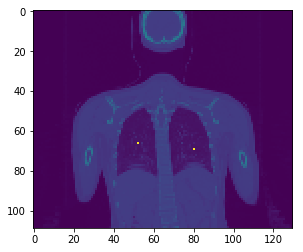

shape segmentação: (109, 130, 130)
shape ground truth: (109, 130, 130)

-----------------------------------------------------------------------------------------
TP, TN, FP, FN: [20575, 1820218, 360, 947]
Elapsed time: 0.031 seconds.


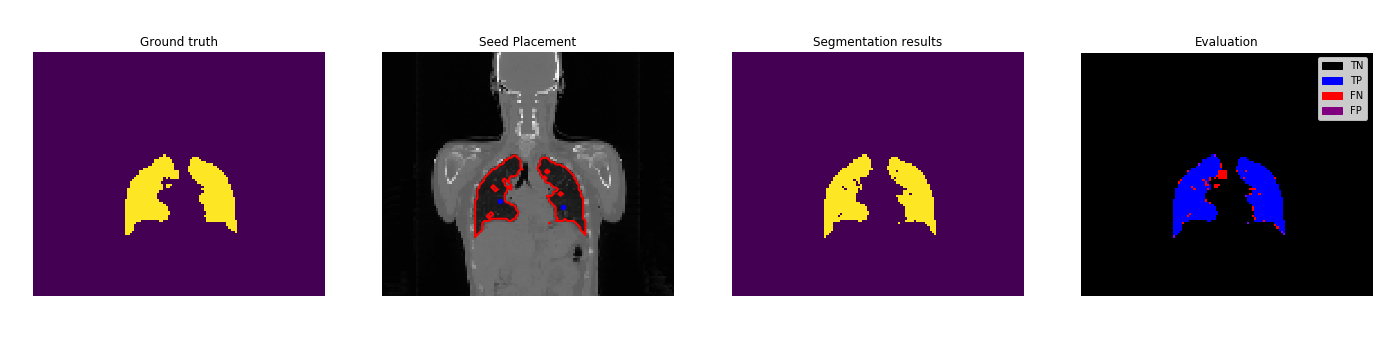

Metrics:
Dice: 0.9692159125703653
Jacquard Index: 0.9402705419979892
True Positive Rate: 0.9559985131493356
Volumetric Similarity: 0.9861742468850837

-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------


In [19]:
from 3DRegionGrowing.segmentation_functions import resample
from preprocess import arrange_slices, normalization, creating_mask
from 3DRegionGrowing.automaticSeeding_third_Version import find_seed #confirmar que não é o primeiro metodo
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io as spio
import pydicom
import time
from segmentation_metrics import compare_volumes_lighter, plot_results_segmentation_image, plotResultsSegmentationImage_WithContours, Dice, Jac, TruePR, VoluM, MutualI
from skimage import measure
import matplotlib.patches as mpatches
#from math import sqrt

def plotResultsSegmentationImage_WithContours2(truth_image_ori, prediction_segment, normal_image, contours,seed_1,seed_2):
    """Code adapted from KenobiShan and from kraskevich, 
    available on https://codereview.stackexchange.com/questions/177898/calculate-true-positive-false-positive-true-negative-and-false-negative-and-co
    This function creates a plot with four images, one from the ct scan with contours from the segmentations,
    another image representing the TP, FP, FN and TN of the segmentations, comparing with the ground truth,
    and two more images, one from the segmentations and other from the ground truth.
    - truth_image_ori - image from the ground truth
    - prediction_segment - image from the predicted segmentation from your code
    - normal_image - image from ct, from the same slice from the other images
    - contours - contours from the segmentation
    """
    prediction = prediction_segment.astype(np.uint8)
    truth_image = truth_image_ori.astype(np.uint8)

    output_image = np.empty(shape=(prediction.shape[0], prediction.shape[1], 4), dtype=np.uint8)

    true_positive_mask = np.logical_and(truth_image ==1 , prediction == 1)
    true_negative_mask = np.logical_and(truth_image ==0 , prediction == 0)
    false_positive_mask = np.logical_and(truth_image ==0 , prediction == 1)
    false_negative_mask = np.logical_and(truth_image ==1 , prediction == 0)
    double_mask = np.where(prediction == 2,1,0)
    background_mask = np.logical_and(truth_image ==0 , prediction == 0)
    
    # B-G-R-A
    red = [255, 0, 0, 255]
    green = [0, 255, 0, 255]
    blue = [0, 0, 255, 255]
    purple =  [128, 0, 255, 255]
    black = [0, 0, 0, 255]
    white = [0,0,0,0]

    output_image[background_mask] = black  
    output_image[true_positive_mask] = blue 
    output_image[true_negative_mask] = black 
    output_image[false_positive_mask] = purple
    output_image[false_negative_mask] = red  
    output_image[double_mask] = white
    
    fig_2 = plt.figure(figsize=(24,6))
    plt.axis('off')
    
    #Plot 1
    k = fig_2.add_subplot(1,4,1)
    k.axis('off')
    yellow_truth = mpatches.Patch(color = 'yellow', label = 'Ground truth')
    k.imshow(truth_image_ori)
    k.set_title("Ground truth")
    
    #Plot 2
    y = fig_2.add_subplot(1,4,2)
    y.axis('off')
    y.imshow(normal_image, interpolation='nearest',cmap = plt.cm.gray)
    for n, contour in enumerate(contours):
        y.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)
    y.scatter([seed_1[2],seed_2[2]], [seed_1[0],seed_2[0]],c='blue',s=20)
    y.set_title("Seed Placement")
    
   
    #Plot 3
    z = fig_2.add_subplot(1,4,3)
    z.axis('off')
    yellow_patch = mpatches.Patch(color ='yellow', label = "Segmented volume")
    if np.amax(double_mask)==1:
        green_patch= mpatches.Patch(color = 'green', label = "Overlapped")
        z.legend(handles=[yellow_patch, green_patch])
    else:
        abc = 1
    z.imshow(prediction_segment)
    z.set_title("Segmentation mask")
    
    #Plot 4    
    x = fig_2.add_subplot(1,4,4)
    x.axis('off')
    black_patch = mpatches.Patch(color='black', label='TN')#'True Negative'
    blue_patch = mpatches.Patch(color='blue', label='TP')#True Positive
    red_patch = mpatches.Patch(color='red', label='FN') #False Negative'
    purple_patch = mpatches.Patch(color='purple', label='FP')#False Positive
    white_patch = mpatches.Patch(color = 'white', label = 'Overlapped segmentations')
    if np.amax(double_mask)==1:
        x.legend(handles=[black_patch, blue_patch, red_patch, purple_patch, white_patch],loc='lower center',fontsize='small')
    else:
        x.legend(handles=[black_patch, blue_patch, red_patch, purple_patch])
    x.imshow(output_image)
    x.set_title("Evaluation")
    plt.show()
    return output_image,fig_2


slices_path = "G:/CTimagens/"
indices_path ="G:/Results/Lungs masks/Separate Lungs/"
seeds_path = "G:/Results/Seeds/third/"
separation_path = "G:/Results/Separator/"
centroid_path = "G:/Results/Centroids/"
segmentations_results_path = "G:/Results/Iterative/third/"
indices_folder= os.listdir(indices_path)
#patients = [31022832, 33515150, 35939665, 38133514, 38564873, 39256095, 40283713, 43151324, 43405561, 48259441, 48335198]
patients = [40283713]


segmentation_folder= os.listdir(segmentations_results_path)
metrics_methods = []
masks = []
resultados = os.listdir(segmentations_results_path)
a = 0
metrics = []
TP_list = []
TN_list = []
FP_list = []
FN_list = []

for num,pre_result in enumerate(patients[0:1]):#pasta dos resultados de cada método

    print('status: '+str(num)+' in '+str(len(patients)))
    print('nome pre-result: ' +str(pre_result))
    result_id = str(pre_result) #split_id.split('_', split_id.count(split_id))[0]
    print('paciente_result: '+str(result_id))
    indexes = os.listdir(indices_path)
    indice_id = str(pre_result)
    indice_id_2 = str(pre_result)
    
    print('indice_mask: '+str(indice_id))

    #Reading data--------------------------------------------------------------------------------------------------
    name_left = str(indice_id_2)+" - ct_left_lung_coordinates.mat"
    if name_left in indexes:
        region = 'left'
        indexes_mask = spio.loadmat(indices_path+ str(indice_id)+" - ct_left_lung_coordinates", squeeze_me=True)["indexes"] #USAR TRY AND CATCH 
    slices = arrange_slices(slices_path,str(indice_id))
    normalized_volume=normalization(slices)
    normalized_array = np.array(normalized_volume)
    volume_resampled,spacing = resample(normalized_array, slices, [5,5,5])

    name_right = str(indice_id_2)+" - ct_right_lung_coordinates.mat"
    if name_right in indexes:
        region = "both"
        indexes_mask_2 = spio.loadmat(indices_path+ name_right, squeeze_me=True)["indexes"] 

    # Ground Truth 1----------------------------------
    ground_truth = creating_mask(indexes_mask,normalized_array)
    ground_truth_resampled,spacing = resample(ground_truth, slices, [5,5,5])
    ground_truth_boolean = np.where(ground_truth_resampled>0.5, 1, 0)

    if name_right in indexes:
    # Ground Truth 2----------------------------------
        ground_truth_2 = creating_mask(indexes_mask_2,normalized_array)
        ground_truth_resampled_2,spacing = resample(ground_truth_2, slices, [5,5,5])
        ground_truth_boolean_2 = np.where(ground_truth_resampled_2>0.5, 1, 0)

    # Segmentation results----------------------------

    result_segment= np.load(segmentations_results_path +'3DVolumeSegmented_'+indice_id+'_left_225.npy') #for 33515150, 435
    result_segment_boolean= np.where(result_segment==True, 1, 0)

    #Seed--------------------------------------------------------------------------------------------------------------------
 
    region = 'left'
    seed_1 = find_seed(seeds_path,indice_id,region, normalized_array, slices)[0]#-- method 3
    region = 'right'
    seed_2 = find_seed(seeds_path,indice_id,region, normalized_array, slices)[0]
    interval = volume_resampled.copy()
    seed = [seed_1,seed_2]
    
    interval[seed[0]]=5000
    interval[seed[1]]=5000
    plt.imshow(interval[:,seed[0][1],:])
    plt.show()
    
        
    # Segmentation results 2---------------------------
    if name_right in indexes:
        result_segment_2= np.load(segmentations_results_path +'3DVolumeSegmented_'+indice_id+'_right_225.npy') #33515150, 255
        result_segment_boolean_2= np.where(result_segment_2==True, 1, 0)
        both_segment = result_segment_boolean+result_segment_boolean_2
        ground_truth_both = ground_truth_boolean+ground_truth_boolean_2
    print('shape segmentação: '+str(result_segment_boolean.shape))
    print('shape ground truth: '+str(ground_truth_boolean.shape))

    print('\n'+'-----------------------------------------------------------------------------------------')

    #Metrics--------------------------------------------------------------------------------------------------------

    if name_right in indexes:
        start=time.time()
        TP, TN, FP, FN = compare_volumes_lighter(ground_truth_both,both_segment)
        stop=time.time()
    else:
        start=time.time()
        TP, TN, FP, FN = compare_volumes_lighter(ground_truth_boolean,result_segment_boolean)
        stop=time.time()
    TP_list.append(TP)
    FP_list.append(FP)
    TN_list.append(TN)
    FN_list.append(FN)
    name = segmentations_results_path+"Metrics_Tp_Fp, Tn, Fn"
    np.save(name, [TP_list,FP_list,TN_list,FN_list])
    
    print('TP, TN, FP, FN: '+str([TP, TN, FP, FN]))
    print("Elapsed time: %.3f seconds." % (stop - start))
    half_rows = result_segment_boolean.shape[1]//2
    
    row = half_rows
    if name_right in indexes:
        contours = measure.find_contours(both_segment[:,row,:], 0.9)
        img, fig = plotResultsSegmentationImage_WithContours2(ground_truth_both[:,half_rows,:],both_segment[:,half_rows,:],volume_resampled[:,row,:], contours,seed[0],seed[1])
    
    else:
        contours = measure.find_contours(result_segment_boolean[:,row,:], 0.9)
        img, fig = plotResultsSegmentationImage_WithContours2(ground_truth_boolean[:,half_rows,:],result_segment_boolean[:,half_rows,:],volume_resampled[:,row,:], contours)

    identification = indice_id+'_'+region
    dice = Dice(TP,FP,FN)
    jac = Jac(TP,FP,FN)
    truePr = TruePR(TP,FN)
    vs = VoluM(TP,FP, FN)
    #mi = MutualI(TP,TN,FP,FN)
    avaliation =tuple([dice,jac,truePr,vs])
    result = tuple([identification,avaliation])
    metrics.append(result)

    print('Metrics:')
    print('Dice: '+str(dice))
    print('Jacquard Index: '+str(jac))
    print('True Positive Rate: '+str(truePr))
    print('Volumetric Similarity: '+str(vs))
    #print('Mutual Information: '+str(mi))
    print('\n'+'-----------------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------------')

    if indice_id == indice_id_2:
        a=a+2
    else:
        a=a+1
metrics_methods.append(metrics)

status: 0 in 12
nome pre-result: 31022832
paciente_result: 31022832
indice_mask: 31022832
shape segmentação: (90, 130, 130)
shape ground truth: (90, 130, 130)

-----------------------------------------------------------------------------------------
TP, TN, FP, FN: [8847, 1465660, 39867, 6626]
Elapsed time: 0.039 seconds.


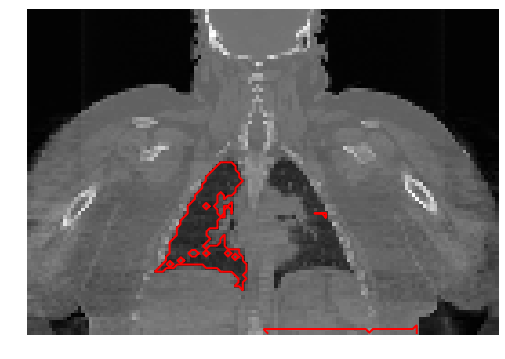

status: 1 in 12
nome pre-result: 33515150
paciente_result: 33515150
indice_mask: 33515150
shape segmentação: (222, 100, 100)
shape ground truth: (222, 100, 100)

-----------------------------------------------------------------------------------------
TP, TN, FP, FN: [11298, 2207972, 377, 353]
Elapsed time: 0.072 seconds.


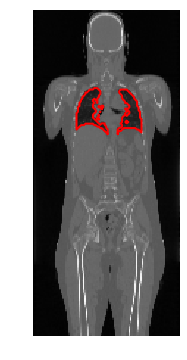

status: 2 in 12
nome pre-result: 35939665
paciente_result: 35939665
indice_mask: 35939665
shape segmentação: (88, 100, 100)
shape ground truth: (88, 100, 100)

-----------------------------------------------------------------------------------------
TP, TN, FP, FN: [17730, 860944, 479, 847]
Elapsed time: 0.012 seconds.


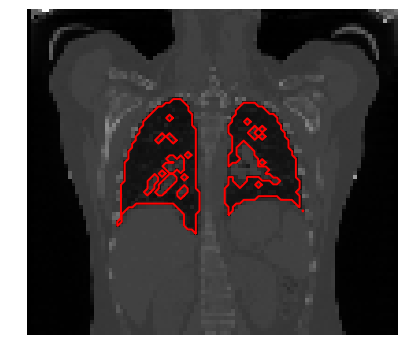

status: 3 in 12
nome pre-result: 38133514
paciente_result: 38133514
indice_mask: 38133514
shape segmentação: (97, 100, 100)
shape ground truth: (97, 100, 100)

-----------------------------------------------------------------------------------------
TP, TN, FP, FN: [31850, 935494, 1148, 1508]
Elapsed time: 0.013 seconds.


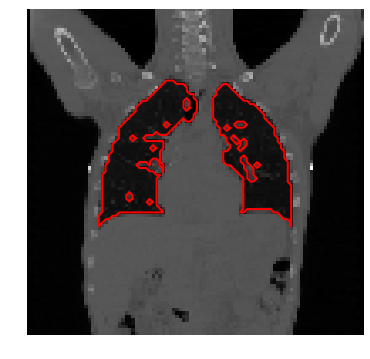

status: 4 in 12
nome pre-result: 38564873
paciente_result: 38564873
indice_mask: 38564873
shape segmentação: (102, 100, 100)
shape ground truth: (102, 100, 100)

-----------------------------------------------------------------------------------------
TP, TN, FP, FN: [19826, 997734, 267, 2173]
Elapsed time: 0.024 seconds.


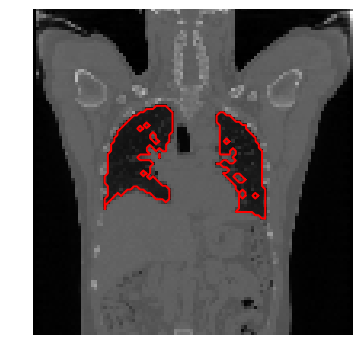

status: 5 in 12
nome pre-result: 39256095
paciente_result: 39256095
indice_mask: 39256095
shape segmentação: (170, 100, 100)
shape ground truth: (170, 100, 100)

-----------------------------------------------------------------------------------------
TP, TN, FP, FN: [19686, 1613058, 38522, 27597]
Elapsed time: 0.035 seconds.


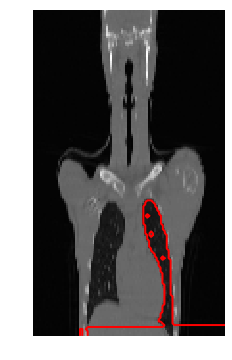

status: 6 in 12
nome pre-result: 40283713
paciente_result: 40283713
indice_mask: 40283713
shape segmentação: (109, 130, 130)
shape ground truth: (109, 130, 130)

-----------------------------------------------------------------------------------------
TP, TN, FP, FN: [20575, 1820218, 360, 947]
Elapsed time: 0.041 seconds.


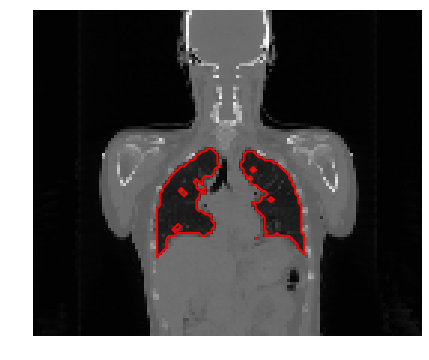

status: 7 in 12
nome pre-result: 43151324
paciente_result: 43151324
indice_mask: 43151324
shape segmentação: (104, 100, 100)
shape ground truth: (104, 100, 100)

-----------------------------------------------------------------------------------------
TP, TN, FP, FN: [13647, 1024815, 322, 1216]
Elapsed time: 0.020 seconds.


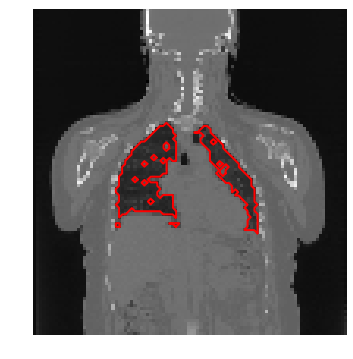

status: 8 in 12
nome pre-result: 48259441
paciente_result: 48259441
indice_mask: 48259441
Im zero
Im zero
Im zero
shape segmentação: (200, 256, 256)
shape ground truth: (200, 256, 256)

-----------------------------------------------------------------------------------------
TP, TN, FP, FN: [72059, 13028603, 2855, 3683]
Elapsed time: 0.281 seconds.


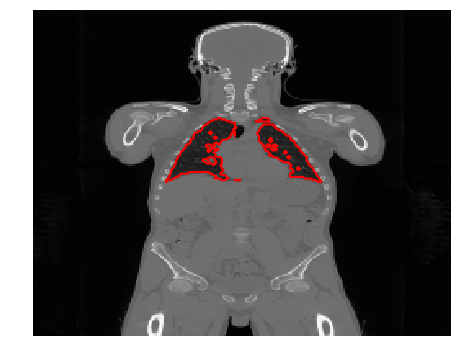

status: 9 in 12
nome pre-result: 49174830
paciente_result: 49174830
indice_mask: 49174830
shape segmentação: (92, 100, 100)
shape ground truth: (92, 100, 100)

-----------------------------------------------------------------------------------------
TP, TN, FP, FN: [19601, 898770, 351, 1278]
Elapsed time: 0.014 seconds.


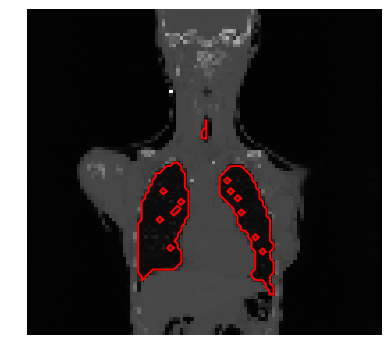

status: 10 in 12
nome pre-result: 52016057
paciente_result: 52016057
indice_mask: 52016057
shape segmentação: (128, 130, 130)
shape ground truth: (128, 130, 130)

-----------------------------------------------------------------------------------------
TP, TN, FP, FN: [19705, 2141609, 530, 1356]
Elapsed time: 0.045 seconds.


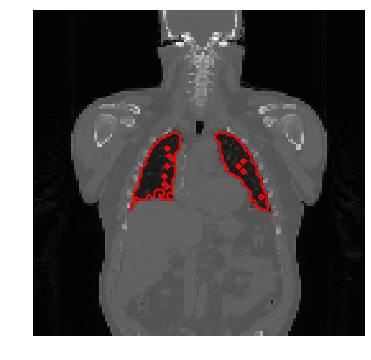

status: 11 in 12
nome pre-result: 57220883
paciente_result: 57220883
indice_mask: 57220883
shape segmentação: (124, 100, 100)
shape ground truth: (124, 100, 100)

-----------------------------------------------------------------------------------------
TP, TN, FP, FN: [14977, 1223837, 178, 1008]
Elapsed time: 0.029 seconds.


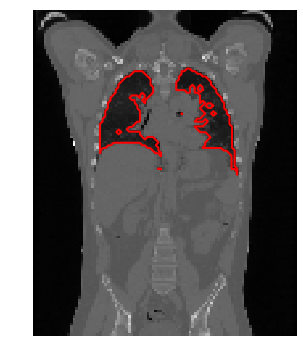

In [9]:
from segmentation_functions import resample
from preprocess import arrange_slices, normalization, creating_mask
from 3DRegionGrowing.automaticSeeding_third_Version import find_seed 
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io as spio
import pydicom
import time
from 3DRegionGrowing.segmentation_metrics import compare_volumes_lighter, plot_results_segmentation_image, plotResultsSegmentationImage_WithContours, Dice, Jac, TruePR, VoluM, MutualI
from skimage import measure
import matplotlib.patches as mpatches
#from math import sqrt

slices_path = "G:/CTimages/original/"
indices_path ="G:/Results/Lungs Masks indexes/ok/Separate Lungs/"
separation_path = "G:/Results/Separator/"
centroid_path = "G:/Results/Centroids/"
segmentations_results_path = "G:/Results/segmentation_results/Iterative/third/"
indices_folder= os.listdir(indices_path)
patients = [31022832, 33515150, 35939665, 38133514, 38564873, 39256095, 40283713, 43151324, 48259441,49174830, 52016057, 57220883]


segmentation_folder= os.listdir(segmentations_results_path)
metrics_methods = []
masks = []
resultados = os.listdir(segmentations_results_path)
a = 8
metrics = []
TP_list = []
TN_list = []
FP_list = []
FN_list = []

for num,pre_result in enumerate(patients): #folder of results for each method
    
    print('status: '+str(num)+' in '+str(len(patients)))
    print('nome pre-result: ' +str(pre_result))
    result_id = str(pre_result)
    print('paciente_result: '+str(result_id))
    indexes = os.listdir(indices_path)
    indice_id = str(pre_result)
    indice_id_2 = str(pre_result)
    print('indice_mask: '+str(indice_id))

    #Reading data--------------------------------------------------------------------------------------------------
    name_left = str(indice_id_2)+" - ct_left_lung_coordinates.mat"
    if name_left in indexes:
        region = 'left'
        indexes_mask = spio.loadmat(indices_path+ str(indice_id)+" - ct_left_lung_coordinates", squeeze_me=True)["indexes"] #USAR TRY AND CATCH 
    slices = arrange_slices(slices_path,str(indice_id))
    normalized_volume=normalization(slices)
    normalized_array = np.array(normalized_volume)
    volume_resampled,spacing = resample(normalized_array, slices, [5,5,5])

    name_right = str(indice_id_2)+" - ct_right_lung_coordinates.mat"
    if name_right in indexes:
        #Reading data 2
        region = "both"
        indexes_mask_2 = spio.loadmat(indices_path+ name_right, squeeze_me=True)["indexes"] 

    # Ground Truth 1----------------------------------
    ground_truth = creating_mask(indexes_mask,normalized_array)
    ground_truth_resampled,spacing = resample(ground_truth, slices, [5,5,5])
    ground_truth_boolean = np.where(ground_truth_resampled>0.5, 1, 0)

    if name_right in indexes:
    # Ground Truth 2----------------------------------
        ground_truth_2 = creating_mask(indexes_mask_2,normalized_array)
        ground_truth_resampled_2,spacing = resample(ground_truth_2, slices, [5,5,5])
        ground_truth_boolean_2 = np.where(ground_truth_resampled_2>0.5, 1, 0)

    # Segmentation results----------------------------

    result_segment= np.load(segmentations_results_path +'3DVolumeSegmented_'+indice_id+'_left_225.npy') #for 33515150, 435
    result_segment_boolean= np.where(result_segment==True, 1, 0)

        
    # Segmentation results 2---------------------------
    if name_right in indexes:
        result_segment_2= np.load(segmentations_results_path +'3DVolumeSegmented_'+indice_id+'_right_225.npy') #33515150, 255
        result_segment_boolean_2= np.where(result_segment_2==True, 1, 0)
        both_segment = result_segment_boolean+result_segment_boolean_2
        ground_truth_both = ground_truth_boolean+ground_truth_boolean_2
    print('shape segmentation: '+str(result_segment_boolean.shape))
    print('shape ground truth: '+str(ground_truth_boolean.shape))

    print('\n'+'-----------------------------------------------------------------------------------------')

    #Metrics--------------------------------------------------------------------------------------------------------
    if name_right in indexes:
        start=time.time()
        TP, TN, FP, FN = compare_volumes_lighter(ground_truth_both,both_segment)
        stop=time.time()
    else:
        start=time.time()
        TP, TN, FP, FN = compare_volumes_lighter(ground_truth_boolean,result_segment_boolean)
        stop=time.time()
    TP_list.append(TP)
    FP_list.append(FP)
    TN_list.append(TN)
    FN_list.append(FN)
    name = segmentations_results_path+"Metrics_Tp_Fp, Tn, Fn"
    np.save(name, [TP_list,FP_list,TN_list,FN_list])
    
    print('TP, TN, FP, FN: '+str([TP, TN, FP, FN]))
    print("Elapsed time: %.3f seconds." % (stop - start))
    half_rows = result_segment_boolean.shape[1]//2

    
    row = half_rows
    if name_right in indexes:
        contours = measure.find_contours(both_segment[:,row,:], 0.9) # #truth_image_ori, prediction_segment, normal_image, contours
        img, fig = plotResultsSegmentationImage_WithContours2(ground_truth_both[:,half_rows,:],both_segment[:,half_rows,:],volume_resampled[:,row,:], contours,seed[0],seed[1])
    
    else:
        contours = measure.find_contours(result_segment_boolean[:,row,:], 0.9)
        img, fig = plotResultsSegmentationImage_WithContours2(ground_truth_boolean[:,half_rows,:],result_segment_boolean[:,half_rows,:],volume_resampled[:,row,:], contours)

    prediction = result_segment_boolean[:,half_rows,:].astype(np.uint8)
    truth_image = ground_truth_boolean[:,half_rows,:].astype(np.uint8)
    y = plt.figure(figsize=(24,6))
    plt.axis('off')
    plt.imshow(volume_resampled[:,row,:], interpolation='nearest',cmap = plt.cm.gray)
    for n, contour in enumerate(contours):
        plt.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)
    plt.show()